# Introdução ao Firedrake  

&nbsp;

## Parte 3: Formulações Mistas

&nbsp;

Ministrante: **Diego Tavares Volpatto (LNCC/ESSS)**
&nbsp;

Encontro Acadêmico de Modelagem Computacional - XV EAMC (2022)

<tr>
<td> <img src="../img/logo_eamc.png" alt="Drawing" style="width: 200px;"/> </td>
<td> <img src="../img/banner.png" alt="Drawing" style="width: 550px;"/> </td>
</tr>

## Sumário

* Exemplo de como solucionar o problema de Poisson reescrito na forma mista
* Problemas com mais de uma incógnita

# Problema de Poisson: Formulação Mista

## Relembrando o problema de Poisson

Encontrar $p \in C^2(\Omega)$ tal que:

\begin{equation}
\begin{cases}
  \nabla \cdot (-K \nabla p) = f & \text{em } \Omega \\[0.5em]
  p = p_D & \text{sobre } \Gamma_D \\[0.5em]
  (-K \nabla p)\cdot \mathbf{n} = g & \text{sobre } \Gamma_N
\end{cases}       
\end{equation}

Podemos reescrever o problema equivalente de 1a ordem definindo o fluxo:

\begin{equation}
\mathbf{u} := - K\nabla p
\end{equation}

E então, substituindo no problema original ($A \equiv K^{-1}$):

\begin{equation}
\begin{cases}
  A \mathbf{u} + \nabla p = \mathbf{0} & \text{em } \Omega \\[0.5em]
  \nabla \cdot \mathbf{u} = f & \text{em } \Omega \\[0.5em]
  p = p_D & \text{sobre } \Gamma_D \\[0.5em]
  \mathbf{u} \cdot \mathbf{n} = g & \text{sobre } \Gamma_N
\end{cases}       
\end{equation}

## Formulação mista

Portanto, agora temos:

\begin{equation}
\begin{cases}
  A\mathbf{u} + \nabla p = \mathbf{0} & \text{em } \Omega \\[0.5em]
  \nabla \cdot \mathbf{u} = f & \text{em } \Omega \\[0.5em]
  p = p_D & \text{sobre } \Gamma_D \\[0.5em]
  \mathbf{u} \cdot \mathbf{n} = g & \text{sobre } \Gamma_N
\end{cases}       
\end{equation}

**Note**: Agora o problema tem duas incógnitas (por isso é chamado de misto):

* Variável primária (escalar): $p$
* Fluxo associado (vetorial): $\mathbf{u}$

## Formulação variacional

O procedimento é o mesmo, porém agora temos dois pares de variáveis {candidata, teste}:

* $\{\mathbf{u}, \mathbf{v}\}$ $\to$ para a eq. do fluxo
* $\{p, q\}$ $\to$ para a eq. de conservação

De forma que, multiplicando pelas respectivas funções-testes, podemos obter:

\begin{equation}
\begin{cases}
  (A\mathbf{u}, \mathbf{v})_\Omega - (p, \nabla \cdot \mathbf{v})_\Omega = -\langle p_D, \mathbf{v} \cdot \mathbf{n} \rangle_{\Gamma_D} & \text{em } \Omega \\[0.5em]
  -(\nabla \cdot \mathbf{u}, q)_\Omega = -(f, q)_\Omega & \text{em } \Omega
\end{cases}       
\end{equation}

Evidentemente, $\mathbf{u}, \mathbf{v} \in H(\text{div}; \Omega)$ e $p, q \in L_2(\Omega)$.

## Estrutura algébrica

O problema variacional resultante então tem a seguinte estrutura algébrica:

\begin{equation}
\mathbf{M} \mathbf{x} = \mathbf{f}
\end{equation}

com

\begin{equation}\label{eq:system_terms}
\mathbf{M} =
    \begin{bmatrix}
        \mathbf{A} & \mathbf{B}^t \\
        \mathbf{B} & \mathbf{0}
    \end{bmatrix};
    \quad
\mathbf{x} =
    \begin{bmatrix}
        \mathbf{u} \\
        \mathbf{p}
    \end{bmatrix};
\quad
\mathbf{f} =
    \begin{bmatrix}
        \mathbf{f}_u \\
        \mathbf{f}_p
    \end{bmatrix}
\end{equation}

Dessa forma, fica transparente a característica de ser um **problema de ponto de cela**.

Devido a estrutura e algumas condições algébricas de solvabilidade (condição de *inf-sup*, elipsidade, etc), as soluções devem pertencer a espaços que satisfaçam certas condições de compatibilidade.

## Espaços de Funções

Devido a estrutura e algumas condições algébricas de solvabilidade (condição de *inf-sup*, elipsidade, etc), as soluções devem pertencer a espaços que satisfaçam certas condições de compatibilidade.

Algumas escolhas clássicas possíveis para pares espaços de dimensão finita que aproximam $H(\text{div})$ e espaços para a variável primária que satisfação a condição de *inf-sup* são:

* Raviart-Thomas (com grau $k + 1$) e $L^2(\Omega)$ (polinômios descontínuos com grau até $k$): RT$_{k+1}$-d$\mathbb{P}_k$
* De forma similar, Brezzi-Douglas-Marini (com grau $k + 1$) e $L^2(\Omega)$ (polinômios descontínuos com grau até $k$): BDM$_{k+1}$-d$\mathbb{P}_k$

**OBSERVAÇÃO**: Em teoria, o grau do espaço de RT não é apresentado como $k+1$. Aqui fazemos assim devido a uma convenção do Firedrake/FEniCS: é o grau do menor polinômio que gera o espaço.

# Implementação

## Considerações

Após essa brevíssima revisão de conceitos-chave para a implementação, vamos proceder como de costume.

Para fins didáticos, vamos considerar o par com RT de menor ordem: $k = 0$. Portanto, a variável primária é contante por partes.

## Importando o Firedrake

Como temos feito ao longo do curso, vamos iniciar importando tudo que for necessário:

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # necessário para o Firedrake

from firedrake import *
import matplotlib.pyplot as plt

plt.style.use(['seaborn-poster'])

## Definindo a malha

Para demonstração, vamos considerar uma malha 2D (quadrado unitário):

In [2]:
N = 10
use_quads = False
mesh = UnitSquareMesh(N, N, quadrilateral=use_quads)

## Declarando os espaços

Agora vamos declarar os espaços de Raviart-Thomas:

In [3]:
if use_quads:
    hdiv_family = 'RTCF'
    pressure_family = 'DQ'
else:
    hdiv_family = 'RT'
    pressure_family = 'DG'

degree = 0
# Para tirar os warnings
cell_type = triangle
RTk = FiniteElement("Raviart-Thomas", cell_type, degree + 1, variant="integral")
U = FunctionSpace(mesh, RTk)
# U = FunctionSpace(mesh, hdiv_family, degree + 1)
V = FunctionSpace(mesh, pressure_family, degree)
W = U * V

Note que, nos problemas mistos, devemos buscar o par $\{\mathbf{u}_h, p_h\} \in \boldsymbol{\mathcal{U}}_h \times \mathcal{V}_h$.

## Declarando as funções

Por estarmos em um espaço misto (ou seja, o problema é resolvido para mais de uma variável), definimos de forma ligeiramente diferente:

In [4]:
u, p = TrialFunctions(W)
v, q = TestFunctions(W)

Note os nomes das funções em plural! (isso pode ser error-prone)

## Solução manufaturada

Agora vamos definir a solução manufaturada e obter o termo de fonte correspondente.

In [5]:
x, y = SpatialCoordinate(mesh)

# Solução exata para a variável primária
p_exact = sin(2 * pi * x) * sin(2 * pi * y)
exact_solution = Function(V).interpolate(p_exact)
exact_solution.rename("Exact pressure", "label")

# Solução exata para o fluxo
# Aqui usamos "project" pq p_exact vem de V
u_exact = Function(U, name='Exact velocity').project(-grad(p_exact))

# Termo-fonte
f_expression = div(-grad(p_exact))
f = Function(V).interpolate(f_expression)

# Tensor de Poisson
A = Constant(1)

## Condições de contorno

No presente problema misto, a condição de Dirichlet é sobre a variável de fluxo! Vamos fixar a condição de contorno com a solução exata:

In [6]:
bcs = DirichletBC(W[0], u_exact, "on_boundary")

Obs.: Nesse caso, não precisaríamos nem definir as CC, visto que não há movimento de corpo livre aqui.

## Formulação variacional

### Forma fraca mista

Recordando:

\begin{equation}
\begin{cases}
  (A\mathbf{u}, \mathbf{v})_\Omega - (p, \nabla \cdot \mathbf{v})_\Omega = -\langle p_D, \mathbf{v} \cdot \mathbf{n} \rangle_{\Gamma_D} & \text{em } \Omega \\[0.5em]
  -(\nabla \cdot \mathbf{u}, q)_\Omega = -(f, q)_\Omega & \text{em } \Omega
\end{cases}       
\end{equation}

Forma abstrata:

\begin{equation}
B(\{\mathbf{u}, p\}; \{\mathbf{v}, q\}) = L(\{\mathbf{v}, q\})
\end{equation}

com

\begin{equation}
B(\{\mathbf{u}, p\}; \{\mathbf{v}, q\}) := (A\mathbf{u}, \mathbf{v})_\Omega - (p, \nabla \cdot \mathbf{v})_\Omega
-(\nabla \cdot \mathbf{u}, q)_\Omega
\end{equation}

\begin{equation}
L(\{\mathbf{v}, q\}) := -(f, q)_\Omega -\langle p_D, \mathbf{v} \cdot \mathbf{n} \rangle_{\Gamma_D}
\end{equation}

In [7]:
n = FacetNormal(mesh)  # Componente normal

a = (dot(u, v) - div(v) * p + q * div(u)) * dx
L = f * q * dx - dot(v, n) * exact_solution * ds

## Problema Variacional e Solver

Finalmente, montando e solucionando o problema:

In [8]:
solver_parameters = {
    "ksp_monitor": None,
    "mat_type": "aij",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
}
solution = Function(W)
problem = LinearVariationalProblem(a, L, solution, bcs=[])
solver = LinearVariationalSolver(problem, solver_parameters=solver_parameters)
solver.solve()

    Residual norms for firedrake_1_ solve.
    0 KSP Residual norm 3.085744339680e+00 
    1 KSP Residual norm 6.166859731481e-15 


## Obtendo os Resultados

Como estamos trabalhando em um problema misto, temos que recuperar a solução de cada variável:

In [9]:
u_h, p_h = solution.split()
u_h.rename('Flux', 'label')
p_h.rename('Pressure', 'label')

## Visualizando os resultados para o fluxo

### Solução exata

### Solução numérica

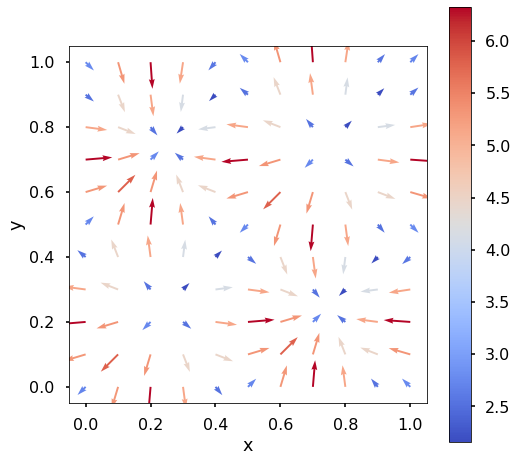

In [10]:
fig, axes = plt.subplots(figsize=(8, 8))
collection = quiver(u_exact, axes=axes, cmap='coolwarm')
fig.colorbar(collection)
axes.set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

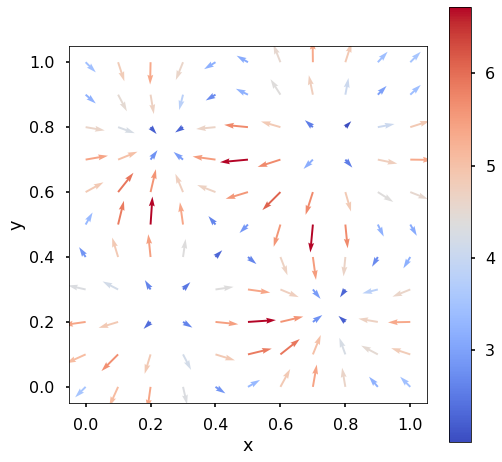

In [11]:
fig, axes = plt.subplots(figsize=(8, 8))
collection = quiver(u_h, axes=axes, cmap='coolwarm')
fig.colorbar(collection)
axes.set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Visualizando os resultados para a pressão

### Solução exata

### Solução numérica

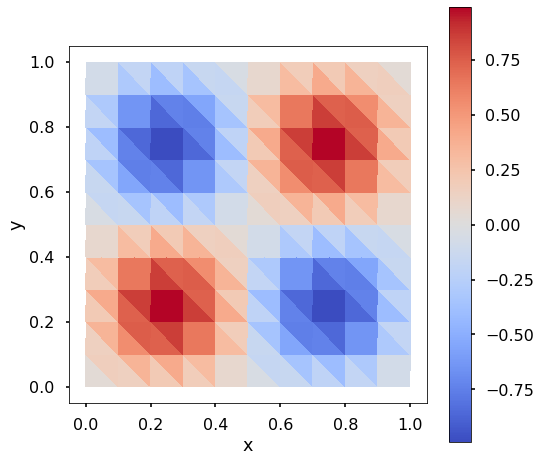

In [12]:
fig, axes = plt.subplots(figsize=(8, 8))
collection = tripcolor(exact_solution, axes=axes, cmap='coolwarm')
fig.colorbar(collection)
axes.set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

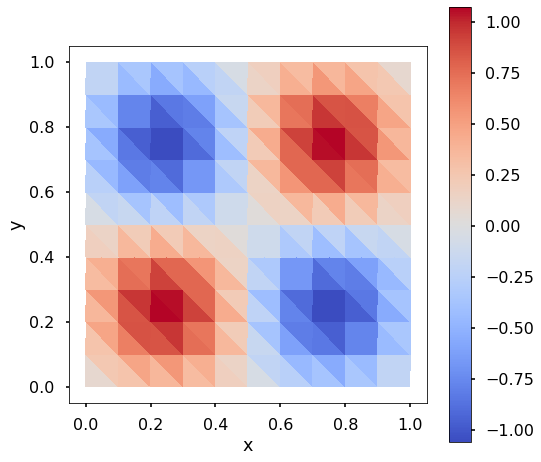

In [13]:
fig, axes = plt.subplots(figsize=(8, 8))
collection = tripcolor(p_h, axes=axes, cmap='coolwarm')
fig.colorbar(collection)
axes.set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.show()